# **PROJECT**
# Part 2

### STUDENTS:


#### - Gal Leibovich 208238352
#### - Amit Mirzayev 206765869

- [Github_Link](https://github.com/galeibo/property-analysis)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt

In [2]:
def prepare_data(df , st , with_price):
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
 # Remove rows without price or with unrealistic prices(only if training or if test data includes prices).  
    if ((st == 'test' and with_price == True) or (st == 'train')):
            df = df.dropna(subset=['price'])
            df = df[(df['price'] > 1000) & (df['price'] < 17000)]
# Drop rows with missing critical columns ,these columns are essential for predicting rental prices
    df = df.dropna(subset=['property_type', 'address', 'floor','neighborhood'])
# Remove duplicate entries based on address, room number, neighborhood, and floor. This prevents duplicate data from biasing the model.
    df = df[~df.duplicated(subset=['address', 'room_num', 'neighborhood','floor'], keep='first')]
# Fill missing values with logical defaults (0, 12, or 0 for specific features)
# For example, fill missing 'garden_area' and 'days_to_enter' with 0    
    df['garden_area'] = df['garden_area'].fillna(0)
    df['days_to_enter'] = df['days_to_enter'].fillna(0)
    df['num_of_payments'] = df['num_of_payments'].fillna(12)
    df['handicap'] = df['handicap'].fillna(0)
    df['num_of_images'] = df['num_of_images'].fillna(0)
    df['num_of_payments'] = df['num_of_payments'].replace(0 , 12)
    df['days_to_enter'] = df['days_to_enter'].replace(-1 , 0)
    df['property_type'] = df['property_type'].replace({
        'דופלקס': 'גג/פנטהאוז',
        'דו משפחתי': "פרטי/קוטג'",
        'מרתף/פרטר': 'כללי',
        'סטודיו/לופט': 'כללי',
        'יחידת דיור': 'כללי'
            })
    df = df.drop('description', axis=1)
# Fill missing 'monthly_arnona' and 'building_tax' with neighborhood averages
# If still missing, fill with 0 (e.g., for basement units)
    df['monthly_arnona'] = df['monthly_arnona'].fillna(df.groupby('neighborhood')['monthly_arnona'].transform('mean'))
    df['monthly_arnona'] = df['monthly_arnona'].fillna(0)
    df['building_tax'] = df['building_tax'].fillna(df.groupby('neighborhood')['building_tax'].transform('mean'))
    df['building_tax'] = df['building_tax'].fillna(0)
# Fix floor and total floors columns using a custom regex function
# Corrects formats and extracts numeric values    
    import re
    def fix_floor(floor, total_floors):
        if pd.isna(total_floors):
            total_floors = ''
        try:
            if int(floor) > int(total_floors):
                if len(floor) == 2 :
                    floors = re.findall("([0-9])([0-9])", floor)
                elif len(floor) == 3 :
                    floors = re.findall("([0-9])([0-9]{2})", floor)
                elif len(floor) == 4 :
                    floors = re.findall("([0-9]{2})([0-9]{2})", floor)
                return  pd.Series([floors[0][0], floors[0][1]])
            else:
                return  pd.Series([floor, total_floors])
        except: 
            if "קרקע" in floor:
                floor = floor.replace('קרקע' , '0')
            floors = re.findall("[0-9]+", floor)
            if len(floors) >= 2:
                return  pd.Series([floors[0], floors[1]])
            elif len(floors) == 1:
                return  pd.Series([floors[0], np.nan])
            else:
                return pd.Series([np.nan, np.nan])
            
    df[['floor', 'total_floors']]  = df.apply(lambda row: fix_floor(row['floor'], row['total_floors']), axis=1)
# Remove rows without total_floors after fixing
# Missing total_floors can impact predictions, so we remove them.
    df = df.dropna(subset=['total_floors'])
# Remove outliers in area and room_num columns
# Keeps only realistic apartment sizes for Tel Aviv rentals    
    df = df[(df['area'] >= 10) & (df['area'] <=200)]
    df = df[df['room_num'] > 0]
# Handle missing distance_from_center values:
# If all values in a neighborhood are missing, drop those rows.
# Otherwise, fill missing values with the neighborhood average.
# This ensures meaningful and consistent data for modeling.
    def handle_distance_from_center(df):
        neighborhoods_with_all_nan = df.groupby('neighborhood')['distance_from_center'].transform(lambda x: x.isna().all())
        if neighborhoods_with_all_nan.any():
            df = df.loc[~neighborhoods_with_all_nan].copy()
        df.loc[:, 'distance_from_center'] = df['distance_from_center'].fillna(df.groupby('neighborhood')['distance_from_center'].transform('mean'))
        return df 
    df = handle_distance_from_center(df)
# Standardize property type names for consistency
    df['floor'] = df['floor'].astype(int)
    df['garden_area'] = df['garden_area'].astype(int)
    df['days_to_enter'] = df['days_to_enter'].astype(int)
    df['num_of_payments'] = df['num_of_payments'].astype(int)
    df['monthly_arnona'] = df['monthly_arnona'].astype(int)
    df['building_tax'] = df['building_tax'].astype(int)
    df['total_floors'] = df['total_floors'].astype(int)
    df['num_of_images'] = df['num_of_images'].astype(int)
    df['handicap'] = df['handicap'].astype(int)
    df['distance_from_center'] = df['distance_from_center'].astype(float)
# Merge variations and unify rare categories
    df['property_type'] = df['property_type'].replace('דירה להשכרה', 'דירה')
    df['property_type'] = df['property_type'].replace('דירת גן להשכרה' , 'דירת גן')
    df['property_type'] = df['property_type'].replace('גג/פנטהאוז להשכרה' ,'גג/פנטהאוז')
    df['property_type'] = df['property_type'].replace('גג/ פנטהאוז' ,'גג/פנטהאוז')
    df['property_type'] = df['property_type'].replace('באתר מופיע ערך שלא ברשימה הסגורה' ,'דירה')
    df['property_type'] = df['property_type'].replace('החלפת דירות' ,'דירה')
    df['property_type'] = df['property_type'].replace('Квартира' ,'דירה')
# Remove non-residential property types (storage units, parking)
    df = df[(df['property_type'] != 'מחסן') & (df['property_type'] != 'חניה')]
# Convert distance from center to meters if needed
# Ensures consistent units for modeling
    def convert_to_meters(row):
        if "דיזינגוף" not in row['address'] and row['distance_from_center'] < 20:
            return row['distance_from_center'] * 1000  
        else:
            return row['distance_from_center']  
    df['distance_from_center'] = df.apply(convert_to_meters, axis=1)
    
# Remove outliers in distance_from_center columns
    df = df[df['distance_from_center'] < 25000]
    
# Feature engineering: add total amenities
# Also, create a binary feature for central apartments
    df['num_of_amenities'] = df[['has_parking', 'has_storage', 'elevator', 'ac', 'handicap', 'has_bars', 'has_safe_room', 'has_balcony', 'is_furnished', 'is_renovated']].sum(axis=1)
    df['is_central'] = (df['distance_from_center'] < 1500).astype(int) 
    
# OneHotEncode property_type column to numeric features
# Saves encoder for consistent test data transformation
    encoder_path = 'encoder_property_type.pkl'
    if st == 'train':
        encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore', dtype=int)
        encoded = encoder.fit_transform(df[['property_type']])
        joblib.dump(encoder, encoder_path)  # שמירה לקובץ
    else:
        if os.path.exists(encoder_path):
            encoder = joblib.load(encoder_path)  # טעינה מהקובץ
            encoded = encoder.transform(df[['property_type']])
        else:
            raise FileNotFoundError(f"{encoder_path} not found. Please run in 'train' mode first.")

    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['property_type']), index=df.index)
    df = pd.concat([df.drop(columns=['property_type']), encoded_df], axis=1)
    
# Create neighborhood_encoded feature using neighborhood average prices
# Provides context about each neighborhood's general price level
    if (st == 'train'):
        neighborhood_map = df.groupby('neighborhood')['price'].mean()
        #neighborhood_map.to_csv('neighborhood_map.csv')
    else:
        neighborhood_map = pd.read_csv('neighborhood_map.csv', index_col=0)['price']   
    df['neighborhood_encoded'] = df['neighborhood'].map(neighborhood_map).fillna(0)
    
# Drop unnecessary or redundant columns
# These columns are either combined elsewhere or not useful for the model
    drop_col = ['neighborhood', 'address','days_to_enter','has_parking', 'has_storage', 'elevator', 'ac',
       'handicap', 'has_bars', 'has_safe_room', 'has_balcony', 'is_furnished','is_renovated',
        'num_of_images','num_of_payments','distance_from_center']
    df = df.drop(drop_col , axis = 1)
# If in training mode, ensure 'price' column is last for clarity  
    if (st == 'train'):
        df = df[[col for col in df.columns if col != 'price'] + ['price']]
    
# Normalize continuous features using StandardScaler
# Keep binary columns unchanged to avoid distorting binary meaning
    scaler_path = 'scaler.pkl'
    features = df.drop("price", axis=1)
    y = df["price"]
    
    binary_cols = [col for col in features.columns if set(features[col].unique()) <= {0, 1}]
    continuous_cols = [col for col in features.columns if col not in binary_cols]
# Save the scaler for consistent test data normalization
    if (st == 'train'):
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features[continuous_cols])
        joblib.dump(scaler, scaler_path)  # שומר לקובץ
    else:
        if os.path.exists(scaler_path):
            scaler = joblib.load(scaler_path)  # טוען מקובץ
            features_scaled = scaler.transform(features[continuous_cols])
        else:
            raise FileNotFoundError(f"{scaler_path} not found. Please run in 'train' mode first.")
            
    df_scaled = pd.concat([pd.DataFrame(features_scaled, columns=continuous_cols).reset_index(drop=True),features[binary_cols].reset_index(drop=True)], axis=1)
    df_scaled["price"] = y.reset_index(drop=True)
        
    #df_scaled = df_scaled.reset_index(drop=True)
 # Return the final cleaned and feature-engineered DataFrame   
    return df_scaled


# Elastic net model

In [3]:
df = pd.read_csv('train.csv')
df.head(2)

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
0,דירה,הצפון הישן החלק המרכזי,"מהר""ל 25",3.0,2,71,NaN,0.0,12.0,467.0,...,1,0,0,1,1,0,0,10150.0,6.0,1005.0
1,דירה,הצפון הישן החלק המרכזי,ארלוזורוב 35,3.0,1,70,NaN,0.0,12.0,240.0,...,1,0,1,0,1,0,0,6600.0,3.0,253.0


In [4]:
clean_df = prepare_data(df , 'train', False)
clean_df.head(2).T

,0,1
room_num,-0.052195,-0.052195
floor,-0.377871,-0.618187
area,-0.338688,-0.371996
garden_area,-0.220305,-0.220305
monthly_arnona,-0.211942,-0.640100
building_tax,0.229697,-0.323606
total_floors,-0.415285,-0.415285
num_of_amenities,0.704120,-0.608371
neighborhood_encoded,0.050765,0.050765
is_central,1.000000,1.000000


### Step 1: Separate the target and features
Separate the target variable (`price`) and the explanatory variables (`X`).

In [5]:
X = clean_df.drop("price", axis=1)
y = clean_df["price"]

### Step 2: Check for multicollinearity using VIF
Calculate the Variance Inflation Factor (VIF) for each feature to identify potential multicollinearity.  
A VIF value above 10 suggests a strong correlation between features, which can be problematic for linear models.

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values(by="VIF", ascending=False)

# Calculate VIF for all features
vif_results = calculate_vif(X)
print(vif_results)

                     feature       VIF
2                       area  4.076781
0                   room_num  3.819948
6               total_floors  2.118939
8       neighborhood_encoded  1.786858
7           num_of_amenities  1.625040
1                      floor  1.549535
5               building_tax  1.533514
9                 is_central  1.389602
4             monthly_arnona  1.339424
3                garden_area  1.332876
10        property_type_דירה  1.306450
11     property_type_דירת גן  1.178084
13  property_type_פרטי/קוטג'  1.148403
12        property_type_כללי  1.099696


### Step 3: Train-test split
Split the dataset into training and testing sets to evaluate model performance.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Step 4: Hyperparameter tuning with GridSearchCV
We use GridSearchCV to find the best combination of hyperparameters (`alpha` and `l1_ratio`) for the ElasticNet model.  
The search uses 10-fold cross-validation to evaluate model performance with each parameter combination.

In [8]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1]
}
model = ElasticNet()
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'alpha': 10, 'l1_ratio': 1}


In [9]:
best_model = grid_search.best_estimator_
print("number of iterations:", best_model.n_iter_)

number of iterations: 26


Since the optimal number of iterations for this model is 26, we did not increase the model's default `max_iter` value.

In [10]:
r2_scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='r2')

print("10-Fold CV R^2 Scores:", r2_scores)
print("Mean R^2:", np.mean(r2_scores))
print("Standard Deviation of R^2:", np.std(r2_scores))

10-Fold CV R^2 Scores: [0.656762   0.51189203 0.62763062 0.59780057 0.68718129 0.60659145
 0.6684672  0.66796299 0.53365615 0.72202845]
Mean R^2: 0.6279972760172423
Standard Deviation of R^2: 0.06337030302753524



- These are the R² scores obtained in each of the 10 cross-validation folds.
- R² indicates the proportion of variance in the target (rental price) explained by the model.

**🔹 Mean R²:**  
`0.6279`  
→ On average, the model explains ~59.7% of the variance in rental prices.

**🔹 Standard Deviation:**  
`0.0633`  
→ Indicates relatively stable performance across folds (low variance).

**Interpretation:**  
The model shows consistent predictive power with moderate variance across different subsets of the data, suggesting reasonable generalization.


### Step 5: Make predictions on the test set
Use the trained model to predict rental prices for the test set.

In [11]:
y_pred = best_model.predict(X_test)

### Step 6: Evaluate model performance
Calculate the RMSE and R² scores to evaluate how well the model predicts rental prices.

In [12]:
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print("📊 ביצועי המודל:")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

📊 ביצועי המודל:
RMSE: 1883.65
R²:   0.581


### Step 7: Identify the top 5 most important features
Retrieve the top 5 features with the highest absolute coefficients from the ElasticNet model.  
These are the features that have the biggest influence on rental price predictions.

In [13]:
coef = pd.Series(best_model.coef_, index=X.columns)
top_elastic = coef.abs().sort_values(ascending=False).head(5)
print("Top 5 most important features:")
print(coef[top_elastic.index].sort_values(ascending=False))

Top 5 most important features:
neighborhood_encoded    1024.665484
area                    1014.807531
is_central               701.451152
property_type_כללי      -657.665364
property_type_דירה      -851.600350
dtype: float64


# Decision tree model

In [14]:
df = pd.read_csv('train.csv')

df_clean = prepare_data(df , 'train', False)
df_clean

,room_num,floor,area,garden_area,monthly_arnona,building_tax,total_floors,num_of_amenities,neighborhood_encoded,is_central,property_type_דירה,property_type_דירת גן,property_type_כללי,property_type_פרטי/קוטג',price
0,-0.052195,-0.377871,-0.338688,-0.220305,-0.211942,0.229697,-0.415285,0.704120,0.050765,1,1,0,0,0,10150.0
1,-0.052195,-0.618187,-0.371996,-0.220305,-0.640100,-0.323606,-0.415285,-0.608371,0.050765,1,1,0,0,0,6600.0
2,-0.536633,-0.618187,-0.538536,-0.220305,-0.338315,-0.375805,-0.415285,0.704120,0.050765,1,1,0,0,0,9000.0
3,-1.021071,-0.137555,-1.371236,-0.220305,-0.904162,-0.441053,-0.531533,-1.920863,0.050765,1,1,0,0,0,5800.0
4,-0.052195,-0.618187,-0.371996,-0.220305,-0.621238,-0.506301,-0.415285,-0.608371,0.050765,1,1,0,0,0,7700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,-0.536633,0.343078,-0.871616,-0.220305,-0.149699,-0.180061,-0.299036,0.704120,-1.112733,0,0,0,0,0,6300.0
590,-0.052195,-0.377871,0.294165,-0.220305,-0.149699,-0.245309,-0.415285,-0.170874,0.350054,1,1,0,0,0,15000.0
591,-1.021071,-0.137555,-0.038915,-0.220305,-0.244007,-0.467152,-0.299036,-0.608371,0.350054,0,1,0,0,0,8000.0
592,-1.989947,-0.137555,-1.704316,-0.220305,-0.753269,-0.506301,-0.531533,-0.608371,-1.112733,0,0,0,1,0,4000.0


### Step 1: Separate the target and features
Separate the target variable (`price`) and the explanatory variables (`X`).

In [15]:
X = df_clean.drop("price", axis=1)
y = df_clean["price"]

### Step 2: Check for multicollinearity using VIF
Calculate the Variance Inflation Factor (VIF) for each feature to identify potential multicollinearity.  
A VIF value above 10 suggests a strong correlation between features, which can be problematic for linear models.

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values(by="VIF", ascending=False)

# Calculate VIF for all features
vif_results = calculate_vif(X)
print(vif_results)

                     feature       VIF
2                       area  4.076781
0                   room_num  3.819948
6               total_floors  2.118939
8       neighborhood_encoded  1.786858
7           num_of_amenities  1.625040
1                      floor  1.549535
5               building_tax  1.533514
9                 is_central  1.389602
4             monthly_arnona  1.339424
3                garden_area  1.332876
10        property_type_דירה  1.306450
11     property_type_דירת גן  1.178084
13  property_type_פרטי/קוטג'  1.148403
12        property_type_כללי  1.099696


### Step 3: Train-test split
Split the dataset into training and testing sets to evaluate model performance.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Step 4: Hyperparameter tuning with GridSearchCV
We chose to use `GridSearchCV` for hyperparameter optimization of the `RandomForestRegressor` model because the number of key parameters we wanted to tune was relatively small and well-defined. Our parameter grid included `n_estimators`, `max_depth`, `min_samples_split`, and `min_samples_leaf` — each with a limited set of reasonable values. This made exhaustive grid search computationally feasible even with 10-fold cross-validation.

Grid Search allowed us to systematically explore all relevant combinations of these parameters and ensured that we did not miss potentially optimal configurations — a limitation sometimes encountered in `RandomizedSearchCV`, especially when the search space is not large.

The optimization was performed using `GridSearchCV` with `cv=10` and `scoring='neg_root_mean_squared_error'` to provide a robust and reliable estimate of the model's performance. This helped us identify a balanced model that avoids overfitting while maintaining predictive accuracy.


In [18]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=10,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,  
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 135 candidates, totalling 1350 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=2)

##### Retrieve the Best-Performing Random Forest Model and Its Optimal Hyperparameters

The best `RandomForestRegressor` model was retrieved from the `GridSearchCV` results,  
along with its optimal hyperparameters as determined by 10-fold cross-validation.

In [19]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


### Step 5: Evaluate the Random Forest with Cross-Validation

We evaluated the best `RandomForestRegressor` model using 10-fold cross-validation.  
The R² scores from each fold were calculated, and the average R² was computed as an indicator of overall model performance.

In [20]:
best_forest = grid_search.best_estimator_
r2_scores_forest = cross_val_score(best_forest, X_train, y_train, cv=10, scoring='r2')
print("10-Fold CV R^2 Scores:", r2_scores_forest)
print("Mean R^2:", np.mean(r2_scores_forest))
print("Standard Deviation of R^2:", np.std(r2_scores_forest))

10-Fold CV R^2 Scores: [0.65204549 0.49230608 0.62980712 0.62835907 0.75629325 0.64521955
 0.80717398 0.66328461 0.50921721 0.69271904]
Mean R^2: 0.6476425397463771
Standard Deviation of R^2: 0.09139913553069288


### Cross-Validation Performance (R² Scores)

- These are the R² scores obtained in each of the 10 cross-validation folds.

- R² indicates the proportion of variance in the target (rental price) that is explained by the model.

**🔹 Mean R²:**  
`0.6476`  
→ On average, the model explains approximately **64.8%** of the variance in rental prices.

**🔹 Standard Deviation:**  
`0.0914`  
→ Indicates **moderate variation** in model performance across different folds.

**Interpretation:**  
The model demonstrates **solid and consistent predictive power**, explaining a meaningful portion of the rental price variance across different subsets of the data. While performance varies slightly between folds, the relatively low standard deviation suggests **reasonable generalization** to unseen data.


### Step 6: Make predictions and evaluate performance on the test set

Using the best `RandomForestRegressor` model from GridSearchCV, we predicted rental prices on the test set.

We evaluated the model using:

- **RMSE:** Measures the average prediction error. Lower is better.
- **R²:** Indicates how much variance in rental prices is explained by the model. Higher is better.

In [21]:
y_pred_forest = best_forest.predict(X_test)
print("Test Set RMSE:", mean_squared_error(y_test, y_pred_forest, squared=False))
print("Test Set R^2:", r2_score(y_test, y_pred_forest))

Test Set RMSE: 1884.2946332117556
Test Set R^2: 0.5803954956283577


### Step 7: Identify the Top 5 Most Important Features

We extracted the top 5 features with the highest importance scores from the `RandomForestRegressor` model.  
These features have the greatest influence on predicting rental prices.

In [22]:
importances = pd.Series(best_forest.feature_importances_, index=X.columns)
top_forest = importances.sort_values(ascending=False).head(5)
print("Top 5 Features:\n", top_forest)

Top 5 Features:
 area                    0.503385
neighborhood_encoded    0.234464
building_tax            0.064524
room_num                0.060114
num_of_amenities        0.034553
dtype: float64


# Top 5 Important Features - Comparison

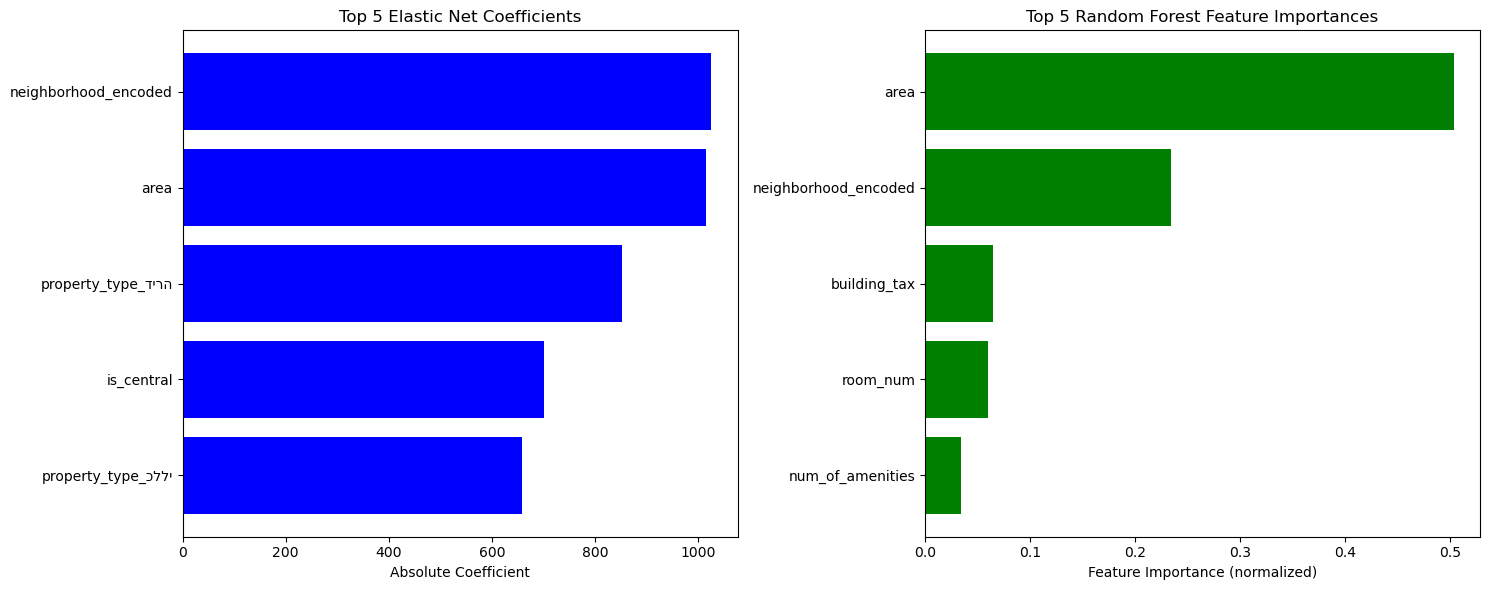

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Elastic Net
axes[0].barh(top_elastic.index, top_elastic.values, color='blue')
axes[0].set_title('Top 5 Elastic Net Coefficients')
axes[0].set_xlabel('Absolute Coefficient')
axes[0].invert_yaxis()  # כדי שהחשוב ביותר למעלה

# Decision Tree
axes[1].barh(top_forest.index, top_forest.values, color='green')
axes[1].set_title('Top 5 Random Forest Feature Importances')
axes[1].set_xlabel('Feature Importance (normalized)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Model Comparison: Elastic Net vs Random Forest

### Model Performance
We compared the two models based on their ability to predict rental prices.

- **Elastic Net** is a linear model that captures direct (additive) relationships between features and the target variable.
- **Random Forest** is a non-linear ensemble model that captures complex feature interactions and threshold effects.

Each model offers different insights into what influences rental prices, with the Random Forest typically performing better on non-linear datasets.

---

### Important Features
We compared the top 5 most influential features identified by each model:

- **Elastic Net :**  
  The top features were `neighborhood_encoded`, `area`, `property_type_מרוהט`, `is_central`, and `property_type_כללי`.  
  This indicates that the linear model emphasized location, apartment size, centrality, and specific property type categories.

- **Random Forest :**  
  The most important features were `area`, `neighborhood_encoded`, `building_tax`, `room_num`, and `num_of_amenities`.  
  The model focused on size, location, number of rooms, building-related costs, and amenities.

---

### Similarities
Both models identified `area` and `neighborhood_encoded` as highly influential features.  
This shows agreement that apartment size and location are key factors in predicting rental prices.

---

### Differences
- **Elastic Net** gave more importance to categorical features like `property_type` and the `is_central` indicator.
- **Random Forest** emphasized numerical and interaction-sensitive features like `building_tax` and `num_of_amenities`, which may reflect non-linear thresholds or combined effects.

---

### Interpretation
The differences stem from the nature of the models:

- **Elastic Net** captures linear relationships and assumes a uniform effect for each feature.  
  It tends to emphasize variables with consistent, additive influence.
  
- **Random Forest** captures non-linear effects and interactions between features.  
  It can detect patterns such as "rents rise sharply when building tax exceeds a certain value" or "amenities matter only when combined with other features".

---

### Conclusion
Both models consistently highlighted `area` and `neighborhood_encoded` as primary predictors of rental prices.  
While the Elastic Net focused on linear influences like centrality and property type, the Random Forest revealed additional non-linear effects through cost and amenity-related features — offering a richer perspective on rental price determinants.